# Ulimate Challenge

## Part 1 - Exploratory data analysis

In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier


pd.options.mode.chained_assignment = None


#Set some global plot defaults
sns.set(rc={"figure.figsize": (18, 6), 'legend.fontsize': 18}) 
plt.rc('axes' , labelsize=18)                                  
plt.rc('xtick', labelsize=18)                                  
plt.rc('ytick', labelsize=18)                                  
plt.rc('axes' , titlesize=18)                                  

In [2]:
logins = pd.read_json('logins.json')

In [3]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [5]:
logins.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [6]:
# Remove the duplicated data and set index
logins.drop_duplicates(inplace=True)
logins.set_index('login_time', inplace=True)

# Add a dummy variable for plotting purposes: each timestamp gets a value of 1
logins['count'] = 1

Examine the entire series at 15 minute intervals.

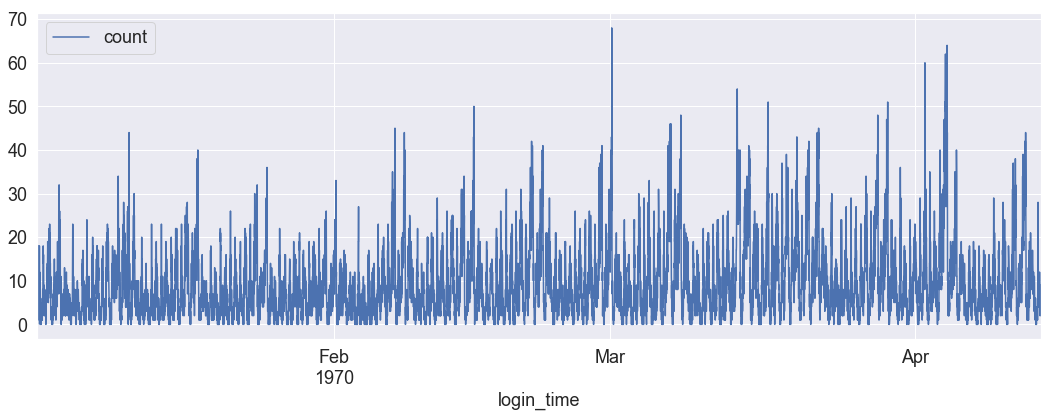

In [19]:
logins.resample('15T').sum().plot()
plt.show()

Look for seaonal patterns at the 24 hr interval.

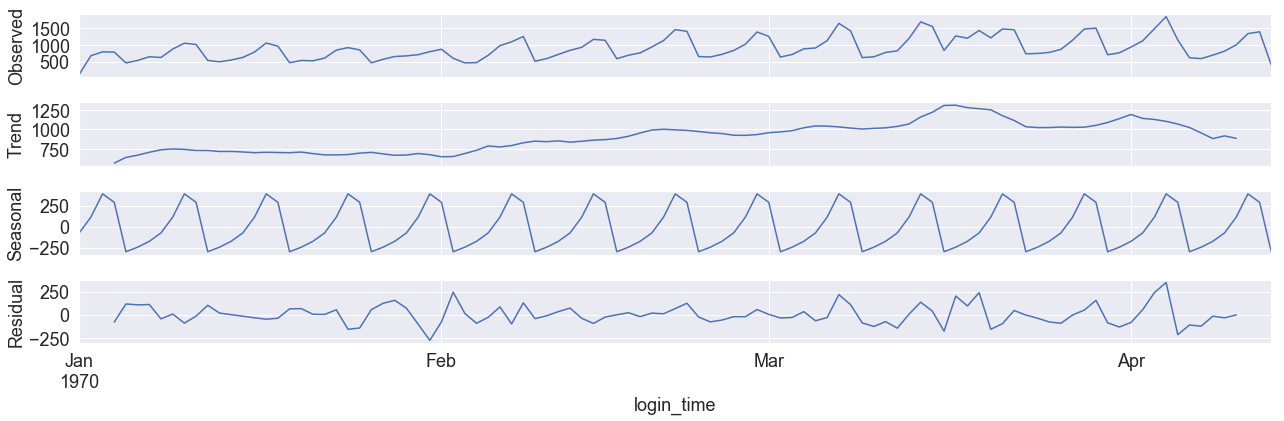

In [14]:
decomposition = sm.tsa.seasonal_decompose(logins.resample('24H').sum())
decomposition.plot()
plt.show()

The lines are really smooth so it is possible the we are losing reasolution so lets look at the 12 hour cycle.

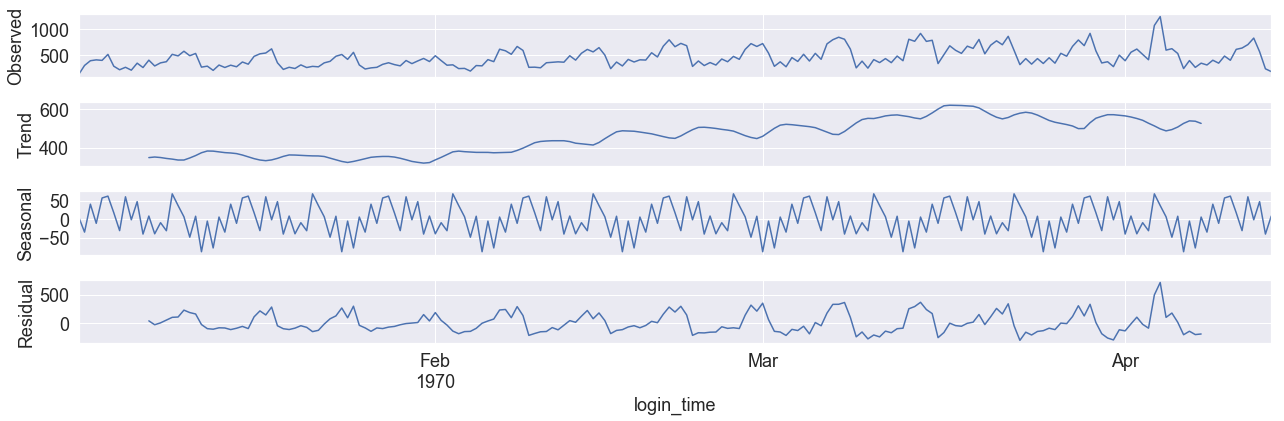

In [20]:
decomposition = sm.tsa.seasonal_decompose(logins.resample('12H', ).sum())
decomposition.plot()
plt.show()

There seems to be a 12 hour cycle that happens. Are there any other cycles. Let's look at the first few months.

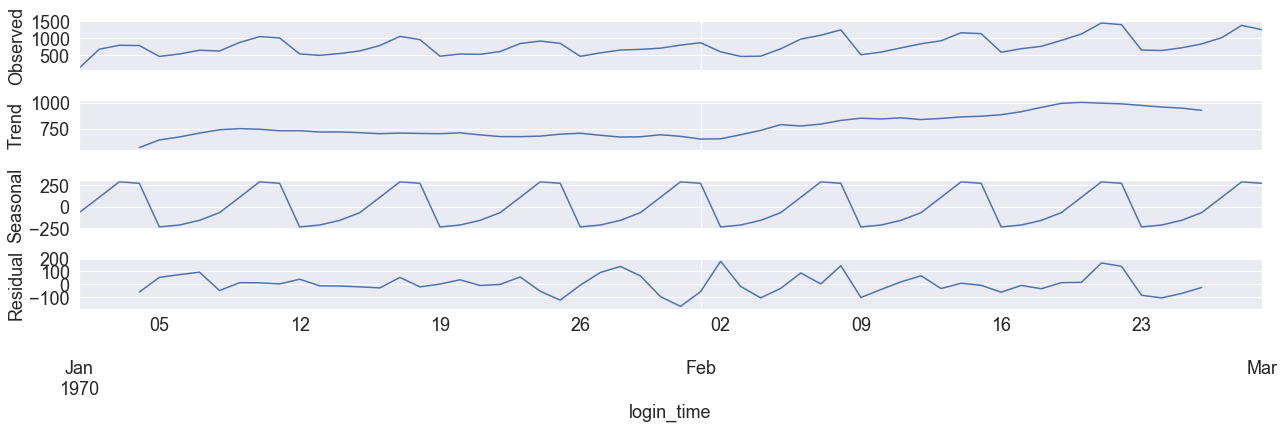

In [16]:
decomposition = sm.tsa.seasonal_decompose(logins.resample('24H').sum()['1970-01-01':'1970-03-01'])
decomposition.plot()
plt.show()

A quick anaylsis of the data a weekly pattern as well.  The total logins are also trending up.

## Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

I would measure the number of times the drivers cross the toll road versus the number of total rides provided in each city. 


Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

* how you will implement the experiment
* what statistical test(s) you will conduct to verify the significance of the observation
* how you would interpret the results and provide recommendations to the city operations team along with any caveats.
       
We can assume data is always being collected. Thus we can measure the city ratios proir to implementation of the experiemnt. It is important to know these numbers before the experiment starts, since that is what we will be comparing to. In some sense, this can be thought of as an A/B test, so we need to know the data very well before the change. Further, we also need to make sure we don't bias or pollute the data by announcing the experiment or change too prematurely. We don't want upcoming news to change behavior making it difficult for us to determine the results of the experiment.

Then we can announce the change and begin the toll reimbursement program. We would then start monitoring the new data. We would have to run the experiment for a fair amount of time to get a true sense of succes. I would recommend 6 months to provide time for the drivers to adopt using the toll road and the novelty of the program to wear of. This will give us the most realistic data. 

We would use a statistical power test to estimate the data required to be able to discern any statistical significance. Then we could run a two-tailed $z$-test comparing sample proportions. This provide $z$-score and associated $p$-value. If the $p$-value is below $0.05$ then we can say the results are statistically significant.

Assuming the incentive does promote cross-city availablity, we need to make sure that the amount of revenue the cities gain is more than the cost of total reimbursement. 

## Part 3 ‐ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

* Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
* Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
* Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice).

### Data Description 
* city: city this user signed up in
* phone: primary device for this user
* signup_date: date of account registration; in the form ‘YYYYMMDD’
* last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
* avg_dist: the average distance in miles per trip taken in the first 30 days after signup
* avg_rating_by_driver: the rider’s average rating over all of their trips
* avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
* surge_pct: the percent of trips taken with surge multiplier > 1
* avg_surge: The average surge multiplier over all of this user’s trips
* trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
* ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
* weekday_pct: the percent of the user’s trips occurring during a weekday

In [26]:
import json

#Load json info
with open('ultimate_data_challenge.json') as f:
    ultimate = json.load(f)

#Convert to dataframe
ultimate = pd.DataFrame(ultimate)

#Convert the time series to datetimes appropriately
ultimate.signup_date = pd.to_datetime(ultimate.signup_date)
ultimate.last_trip_date = pd.to_datetime(ultimate.last_trip_date)

ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [49]:
len(ultimate['avg_rating_of_driver'].dropna())/len(ultimate)

0.83756

In [48]:
len(ultimate.drop(['avg_rating_of_driver'], axis=1).dropna())/len(ultimate)

0.98812

There is a significate amount of data missing from avg_rating_of_driver. This could result in highly skewed data thus I have choosen to drop the feature from consideration.

In [50]:
ultimate.drop(['avg_rating_of_driver'], axis=1, inplace=True)

In [51]:
ultimate.describe()

,avg_dist,avg_rating_by_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,8.000000,100.000000,125.000000,100.000000


In [52]:
ultimate[['signup_date', 'last_trip_date']].describe()

,signup_date,last_trip_date
count,50000,50000
unique,31,182
top,2014-01-18 00:00:00,2014-06-29 00:00:00
freq,2948,2036
first,2014-01-01 00:00:00,2014-01-01 00:00:00
last,2014-01-31 00:00:00,2014-07-01 00:00:00


In [53]:
ultimate['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

Now the data needs to be prepared for the model.

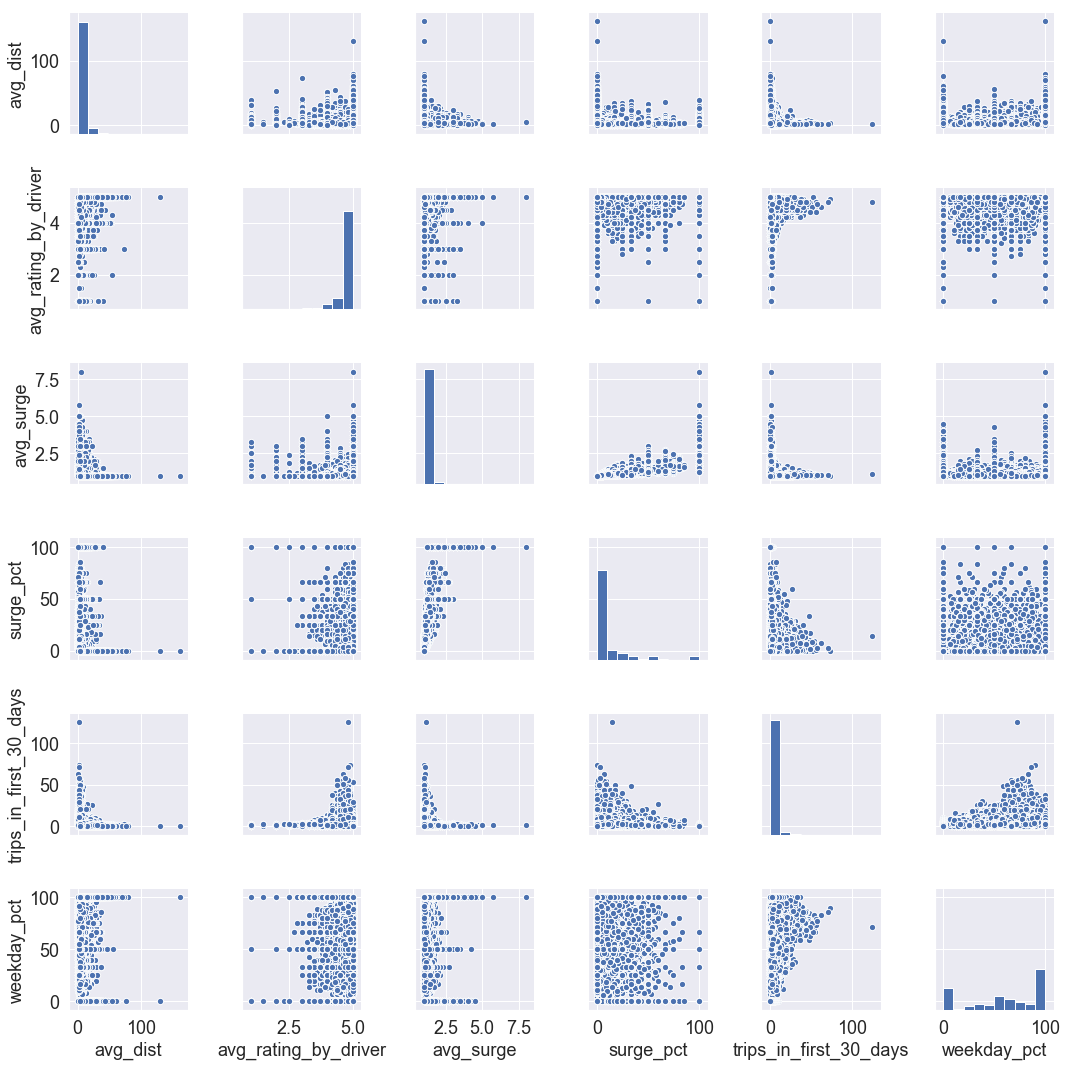

In [56]:
g = sns.PairGrid(ultimate.drop(['city','last_trip_date', 'phone', 'signup_date', 'ultimate_black_user'], axis=1))
g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_offdiag(plt.scatter, edgecolor="w", s=40)

There are still some outliers in the data. I will remove those using a 98% confidence interval.

In [81]:
z = np.abs(stats.zscore(ultimate.drop(
    columns = ['city','last_trip_date', 'phone', 'signup_date', 'ultimate_black_user','avg_rating_by_driver'])))

ultimate = ultimate[(z < 2.33).all(axis=1)]

In [85]:
ultimate.reset_index(inplace=True, drop=True)

/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


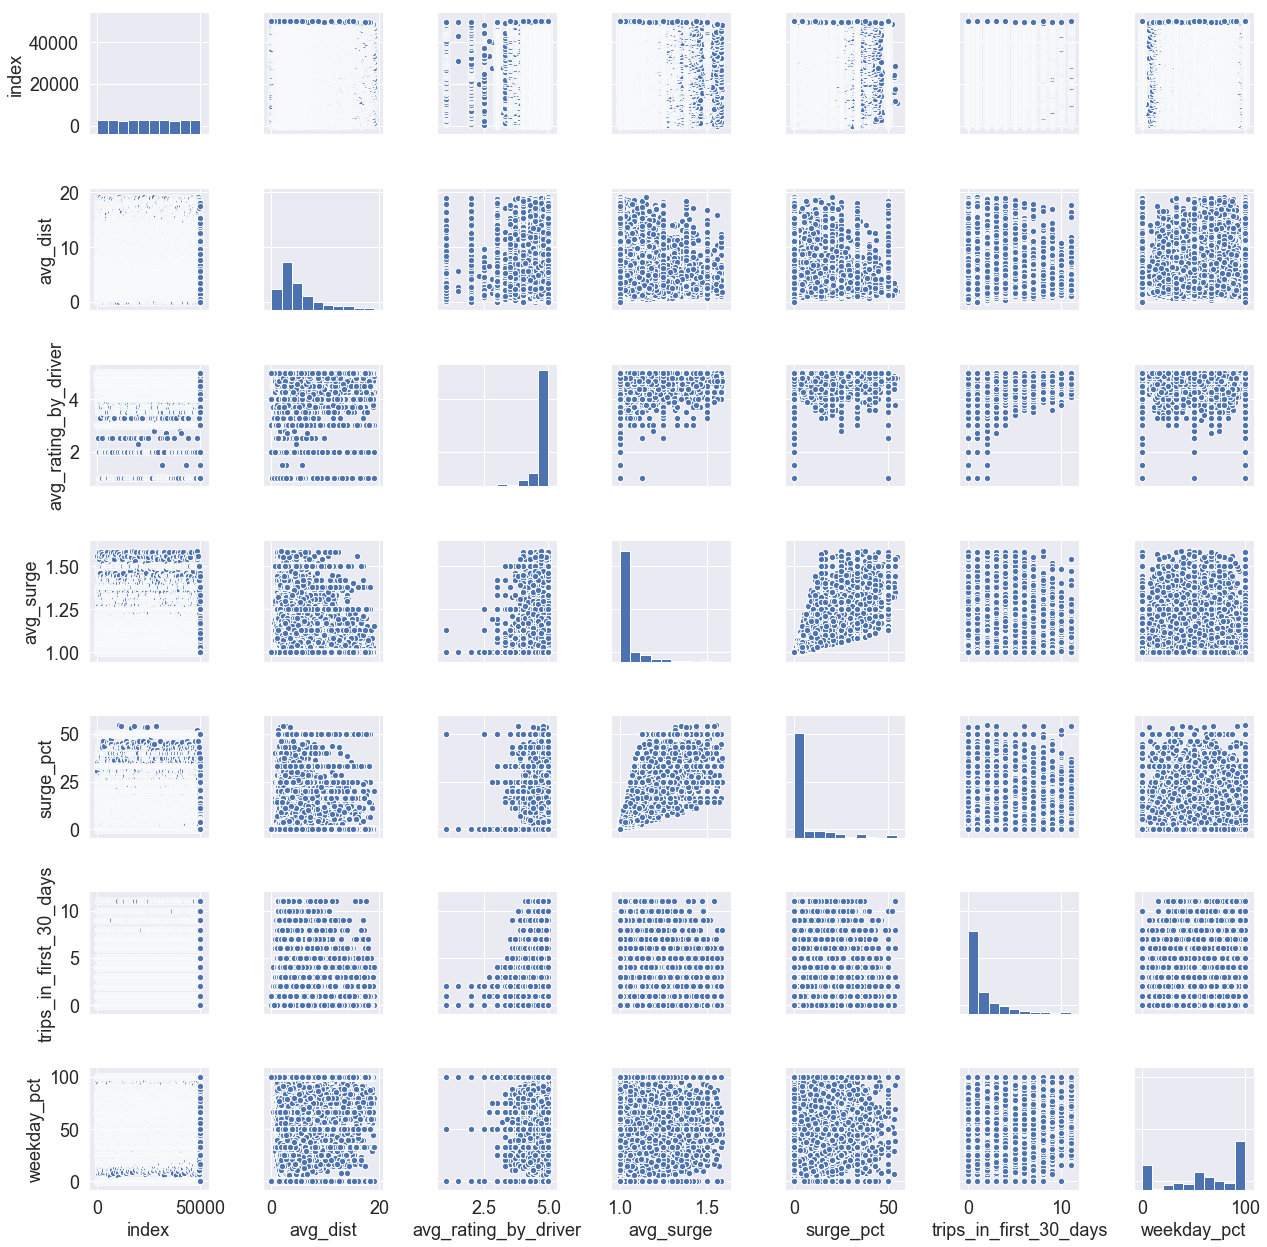

In [86]:
g = sns.PairGrid(ultimate.drop(['city','last_trip_date', 'phone', 'signup_date', 'ultimate_black_user'], axis=1))
g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_offdiag(plt.scatter, edgecolor="w", s=40)

In [105]:
active_dict = {x:False for x in range(0, len(ultimate))}

#Loop over rows
for i in range(len(ultimate)):
    
    #Set the start date of this row
    start = ultimate['signup_date'][i]
    
    #Set the end date for this row: 6 months later
    end = start + pd.Timedelta('181D')
    
    #Set the time window, a month before end date
    previous = end - pd.Timedelta('30D')
    
    #Was the last trip within the last month?
    if previous <= ultimate['last_trip_date'][i] <= end:
        active_dict[i] = True


#Add active user info to the dataframe
ultimate['is_active'] = pd.DataFrame(active_dict.items(), columns=['ind', 'active'])['active'].copy()

print('There are {0} ({1}%) active users.'.format(ultimate.is_active.sum(), 
                                                    round(ultimate.is_active.sum()*100./len(ultimate),2))) 

There are 10947 (24.42%) active users.


/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The date fields are now encompassed by the is_active feature.

In [106]:
ultimate.drop(['last_trip_date', 'signup_date'], axis=1, inplace=True)

/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [156]:
ultimate = pd.get_dummies(ultimate, drop_first=False)
ultimate.columns

Index(['index', 'avg_dist', 'avg_rating_by_driver', 'avg_surge', 'surge_pct',
       'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct',
       'is_active', 'city_Astapor', 'city_King's Landing', 'city_Winterfell',
       'phone_Android', 'phone_iPhone'],
      dtype='object')

In [157]:
ultimate.dropna(inplace=True)
ultimate.drop(columns=['index'], inplace=True)

The model can now be built:

In [158]:
ultimate = pd.get_dummies(ultimate, drop_first=False)
ultimate.columns

#Split into train/test
x_train, x_test, y_train, y_test = train_test_split(ultimate.drop(columns=['is_active']), 
                                                    ultimate.is_active, test_size = 0.2, random_state=1221, 
                                                    stratify=ultimate.is_active)

In [159]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [160]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1220)

In [161]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [162]:
#Setup the RF object
rf = RandomForestClassifier(criterion='gini', class_weight='balanced', n_jobs=-1)

#Hyperparameter grid
param_grid = {'n_estimators' : [40, 50, 60, 80, 100],
              'min_samples_split' : [2, 3, 4], 
              'max_depth' : [4, 7, 10, 18, 22]}

#Setup the Gridsearch
rf_cv = GridSearchCV(rf, param_grid, cv=cv, scoring='roc_auc', verbose=1)

#Fit the data
rf_cv.fit(x_train, y_train)

#Print out the best model
print('Best RF Params: {}'.format(rf_cv.best_params_))
print('Best RF Score : %f' % rf_cv.best_score_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed:  3.8min finished


Best RF Params: {'max_depth': 10, 'min_samples_split': 4, 'n_estimators': 100}
Best RF Score : 0.809612


In [163]:
rf_best = RandomForestClassifier(criterion='gini', class_weight='balanced', n_jobs=-1, 
                                 n_estimators=rf_cv.best_params_['n_estimators'],
                                 min_samples_split=rf_cv.best_params_['min_samples_split'], 
                                 max_depth=rf_cv.best_params_['max_depth'])

rf_best.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [164]:
from sklearn.model_selection import cross_val_score

#Print the score/metric for the input model which must be fit
def get_scores(model, name='unk', score=roc_auc_score):
    
    #Make prediction for the model
    pred = model.predict(x_test)
    pred_prob = model.predict_proba(x_test)[:,1]

    #Calculate the score on the entire test set
    auc = score(y_test, pred_prob)
    
    #Calculate the score on CV test set
    cv_scores = cross_val_score(model, x_test, y_test, cv=cv, scoring='roc_auc')
    mean_cv = cv_scores.mean()
    std_cv = cv_scores.std()
    
    #Save to dataframe to be used for printing only
    model_score = pd.DataFrame(columns=['Model', 'Test score', 'CV score'])
    model_score.loc[0] = [name, auc, mean_cv]
    model_score.set_index('Model', inplace=True)
    print(model_score)
    
    


In [165]:
get_scores(rf_best, "Random Forest")

               Test score  CV score
Model                              
Random Forest    0.811265  0.796947


In [166]:
pd.DataFrame(zip(ultimate.columns, rf_best.feature_importances_), columns=['Feature','Value']).\
   sort_values('Value', ascending=False).reset_index(drop=True)

,Feature,Value
0,avg_rating_by_driver,0.162481
1,weekday_pct,0.158504
2,surge_pct,0.153132
3,avg_surge,0.113370
4,avg_dist,0.100043
5,city_Astapor,0.077911
6,trips_in_first_30_days,0.068127
7,city_Winterfell,0.044373
8,phone_Android,0.041973
9,ultimate_black_user,0.038299


The most import predictors of rider retention are 'avg_rating_by_driver' (rating of all trips), 'weekday_pct' (trips in weekdays) and 'surge_pct' (usage). The average trip rating and surge percentage makes sense because the happier a passenger is with the service the more they will use it. Also riders use the service just to get home safely after a night out are less lately to have long term rentention so the percentage of weekday rides comes into play.


By looking at the feature importance we can also see that passengers from Astaphor are more likely to be retained than Winterfell and King's Landing riders. Ultimate may consider perfroming target marketing to the Winterfell and King's Landing markets to increase return customers. 